## Profile of buoyancy in OCS-Papa

This notebook compares the simulated buoyancy among all schemes in the OCS-Papa case.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import num2date
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools', )
from gotmanalysis import GOTMOutputDataSet 
%matplotlib inline

In [2]:
# list of turbulent methods
turbmethod_list = ['KPP-CVMix',
                   'KPP-ROMS',
                   'KPPLT-EFACTOR',
                   'KPPLT-ENTR',
                   'KPPLT-RWHGK',
                   'EPBL',
                   'EPBL-LT',
                   'SMC',
                   'SMCLT',
                   'K-EPSILON-SG',
                   'OSMOSIS']
legend_list = ['KPP-CVMix',
               'KPP-ROMS',
               'KPPLT-VR12',
               'KPPLT-LF17',
               'KPPLT-R16',
               'ePBL',
               'ePBL-LT',
               'SMC-KC94',
               'SMCLT-H15',
               '$k$-$\epsilon$-SG95',
               'OSMOSIS']
dir_in = os.environ['GOTMRUN_ROOT']+'/TEST_RES_dampV_5d'
dir_out = os.environ['GOTMFIG_ROOT']+'/TEST_RES_dampV_5d'
# list of location
irow_2col = [1, 2, 0, 1, 2, 3, 3, 4, 4, 5, 5]
icol_2col = [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]
labels_2col = ['(b)', '(c)', '(g)', '(h)', '(i)', '(d)', '(j)', '(e)', '(k)','(f)','(l)']
case = 'OCSPapa_20120321-20130320'
var = 'buoy'
c_max = 3.5e-2
c_min = 5e-3
d_max = 1e-2
depth = -130
# location of legend
xloc = 0.1
yloc = 0.2

In [3]:
 # input data directory
dataroot = dir_in+'/'+case
# paths of files 
nm = len(turbmethod_list)
paths = [dataroot+'/'+turbmethod_list[i]+'_VR1m_DT60s/gotm_out.nc' for i in range(nm)]
# initialize dataset
data = GOTMOutputDataSet(paths=paths, keys=turbmethod_list)

In [4]:
# output figure name
figdir = dir_out+'/'+case
os.makedirs(figdir, exist_ok=True)

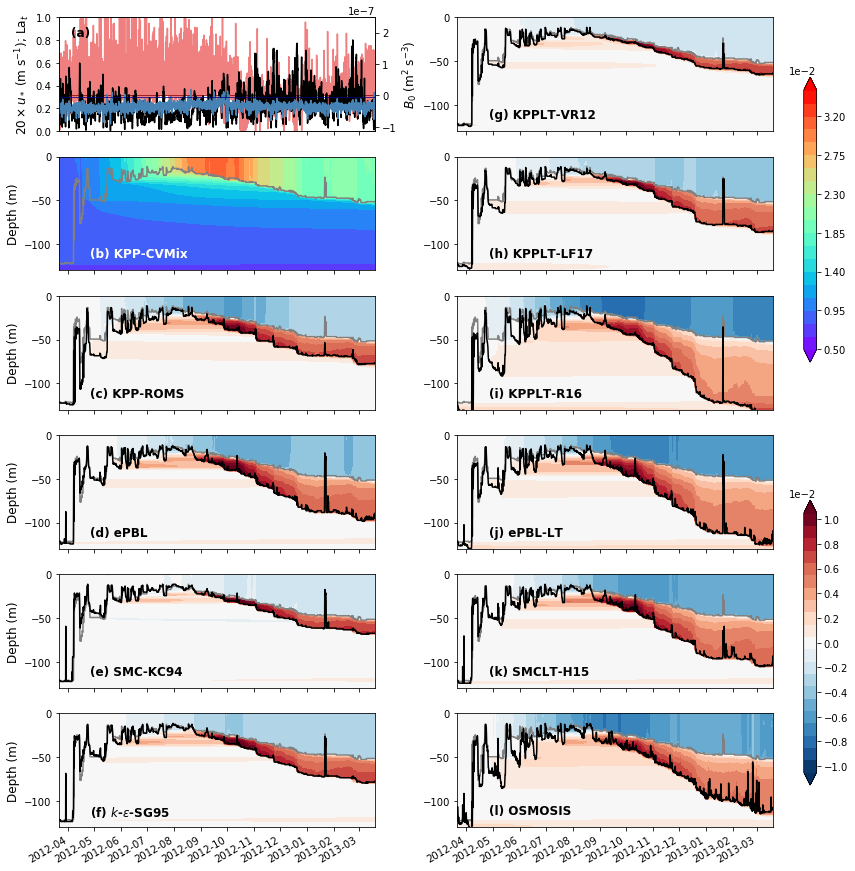

In [5]:
# figure
nrow = (nm+2)//2
fig_width = 12
fig_height = 2.5+2*(nrow-1)

# plot figure
height_ratios = [1]*nrow
height_ratios.append(0.15)
width_ratios = [1, 1, 0.05]
f, axarr = plt.subplots(nrow, 2, sharex='col')
f.set_size_inches(fig_width, fig_height)

# contour levels
c_int = (c_max-c_min)/20
levels0 = np.arange(c_min, c_max+c_int/2, c_int)
d_int = d_max/10
levels1 = np.arange(-d_max-0.5*d_int, d_max+d_int, d_int)
cb_ticks = np.arange(-d_max, d_max+d_int*2, d_int*2)

    
# panel a
gotmdata0 = data.cases['KPP-CVMix']
dttime0 = num2date(gotmdata0.time, units=gotmdata0.time_units,
                   calendar=gotmdata0.time_calendar)
ustar0  = gotmdata0.read_timeseries('u_taus').data
laturb0 = gotmdata0.read_timeseries('La_Turb').data
hoLmo0  = gotmdata0.read_timeseries('hoLmo').data
bflux0  = gotmdata0.read_timeseries('bflux').data
par1 = axarr[0, 0].twinx()
axarr[0, 0].plot(dttime0, ustar0*20, color='black', linewidth=1.5)
axarr[0, 0].set_ylabel('$20 \\times u_*$ (m s$^{-1}$); $\mathrm{La}_t$', fontsize=12)
axarr[0, 0].set_ylim([0, 1])
axarr[0, 0].plot(dttime0, laturb0, color='steelblue', linewidth=1.5)
axarr[0, 0].axhline(0.3, color='navy', linewidth=0.75)
par1.plot(dttime0, bflux0, color='lightcoral', linewidth=1.5)
par1.set_ylabel('$B_0$ (m$^2$ s$^{-3}$)', fontsize=12)
ymax = np.percentile(bflux0, 99)
ymin = np.percentile(bflux0, 1)
par1.set_ylim([ymin, ymax])
par1.axhline(0, color='darkred', linewidth=0.75)
axarr[0, 0].set_zorder(par1.get_zorder()+1)
axarr[0, 0].patch.set_visible(False)
axarr[0, 0].text(0.04, 0.92, '(a)', transform=axarr[0, 0].transAxes,
                 fontsize=12, fontweight='bold', va='top')

# panel b
n = icol_2col[0]
m = irow_2col[0]
# get var
prfl = gotmdata0.read_profile(var)
fld0 = prfl.data
z0 = prfl.z
# get mld
mld0 = gotmdata0.read_timeseries('mld_deltaR').data
im0 = axarr[m, n].contourf(dttime0, z0, np.transpose(fld0), levels0,
                           extend='both', cmap='rainbow')
axarr[m, n].set_ylabel('Depth (m)', fontsize=12)
axarr[m, n].set_ylim([depth, 0]) 
axarr[m, n].plot(dttime0, -mld0, color='gray', linewidth=1.5)
axarr[m, n].text(xloc, yloc, labels_2col[0]+' '+legend_list[0],
                 transform=axarr[m, n].transAxes, color='white',
                 fontsize=12, fontweight='bold', va='top')

# panel c-l
# loop over other turbmethods
cmap = plt.cm.get_cmap('RdBu_r', 61)
for i in np.arange(nm-1):
    j = i+1 
    n = icol_2col[j]
    m = irow_2col[j]
    gotmdata1 = data.cases[turbmethod_list[j]]
    dttime1 = num2date(gotmdata1.time, units=gotmdata1.time_units,
                       calendar=gotmdata1.time_calendar)
    # get var
    prfl = gotmdata1.read_profile(var)
    fld1 = prfl.data
    z1 = prfl.z
    # get mld
    mld1 = gotmdata1.read_timeseries('mld_deltaR').data
    im1 = axarr[m, n].contourf(dttime1, z1, np.transpose(fld1-fld0), levels1,
                               extend='both', cmap=cmap)
    if n == 0:
        axarr[m, n].set_ylabel('Depth (m)', fontsize=12)
    axarr[m, n].set_ylim([depth, 0]) 
    axarr[m, n].plot(dttime0, -mld0, color='gray', linewidth=1.5)
    axarr[m, n].plot(dttime0, -mld1, color='black', linewidth=1.5)
    axarr[m, n].text(xloc, yloc, labels_2col[j]+' '+legend_list[j],
                     transform=axarr[m, n].transAxes, fontsize=12,
                     fontweight='bold', va='top')

 # reduce margin
plt.tight_layout()

# auto adjust the x-axis label
plt.gcf().autofmt_xdate()

plt.subplots_adjust(bottom=0.075, right=0.9)
cax0 = plt.axes([0.85, 0.55, 0.1, 0.4])
cax0.set_visible(False)
cb0 = plt.colorbar(im0, ax=cax0)
cb0.formatter.set_powerlimits((-2, 2)) 
cb0.update_ticks()
cax1 = plt.axes([0.85, 0.08, 0.1, 0.4])
cax1.set_visible(False)
cb1 = plt.colorbar(im1, ax=cax1, ticks=cb_ticks)
cb1.formatter.set_powerlimits((-2, 2)) 
cb1.update_ticks()

# save figure
# figname = figdir+'/Pfl_cmp_turbmethods_'+var+'.png'
# plt.savefig(figname, dpi = 300)

# # close figure
# plt.close()